In [1]:
from __future__ import absolute_import, division, print_function
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar100, cifar10
from tqdm import tqdm
from IPython.display import clear_output

from scan_tf.models.resnet import resnet_18, resnet_34, resnet_50, resnet_101, resnet_152

# Grow memory to avoid mem overflow
memory_growth=False
if memory_growth:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
      except RuntimeError as e:
        print(e)

In [14]:
# Model configuration
img_width, img_height, img_num_channels = 32, 32, 3
no_epochs = 100
optimizer = tf.keras.optimizers.Adam()
validation_split = 0.2
verbosity = 1

# Load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Find number of classes dynamically
num_classes = np.unique(y_train).shape[0]

X_train.shape
input_train = X_train
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Parse numbers as floats
input_train = X_train .astype('float32')
input_test = X_test.astype('float32')

# Normalize data
X_train = (X_train / 255).astype(np.float32)
X_test = (X_test / 255).astype(np.float32)

10


In [4]:
model = resnet_18(num_classes=num_classes)
model.build(input_shape=(None, img_width, img_height, img_num_channels))

In [5]:
# model.load_weights("resnet18_classification_with_rotnet.h5")

In [6]:
# model = tf.keras.models.load_model('resnet18_classification_with_rotnet.h5')
# # latest = tf.train.latest_checkpoint(checkpoint_dir)
# # # Load the previously saved weights
# # model.load_weights(latest)


# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

<h3>Training for minimizing the Rotation Loss</h3>

In [12]:
lr = 1e-4
e = 1
m = X_train.shape[0]
batch_size = 128

while True:
    e+=1
    batch_count = 0
#     for idx in tqdm(range(0, m, batch_size)): # batch
    for idx in range(0, m, batch_size): # batch
        images = tf.convert_to_tensor(X_train[idx:idx+batch_size, ...])
        labels = tf.convert_to_tensor(y_train[idx:idx+batch_size, ...])
        
        degrees_to_rotate = np.random.choice([90, 180, 270]) # randomly choosing the rotation angle
        
        images_rotated = tf.convert_to_tensor(scipy.ndimage.rotate(images, degrees_to_rotate, axes=(2, 1))) 

        with tf.GradientTape() as tape:
            embs_a, embs_b = model(images), model(images_rotated)
#             loss = tf.norm(embs_a-embs_b, ord='euclidean', axis=None, keepdims=None, name=None)
            loss = tf.reduce_sum(tf.norm(embs_a-embs_b, ord='euclidean', axis=(1), keepdims=None, name=None))

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer = tf.keras.optimizers.Adam(lr=lr)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        #if batch_count%1==0:
            # mean_acc = np.mean(find_neighbor_accuracy(embs_a))
            # print(f"\tbatch {batch_count}, loss: {tf.reduce_sum(loss).numpy()}, mean_acc: {mean_acc}")
        batch_count+=1
    if e%1 == 0:
        clear_output()
        print(f"epoch {e}, loss: {loss}")
    if e==10:
        break

epoch 3, loss: nan


KeyboardInterrupt: 

In [9]:
# model.save_weights("resnet18_classification_with_rotnet.h5")

In [152]:
embeddings = model(images)
np.mean(find_neighbor_accuracy(embeddings))

In [114]:
true_classes = np.argmax(labels, axis=1)

In [81]:
# plt.imshow(images.numpy()[np.where(true_classes==0)[0]][6])

In [35]:
embeddings.shape

(100, 10)

<h3>Finding Nearest Neighbors</h3>

In [148]:
np.mean(accuracies)

0.11024305555555557

In [150]:
# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
def find_neighbor_accuracy(embeddings, plot=False):
    embeddings = embeddings.numpy()
    nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    accuracies = list()
    for i in range(len(true_classes)):
        true_class = true_classes[i]
        predicted_classes = true_classes[indices[i]][1:]
        accuracy = (predicted_classes==true_class).sum()/predicted_classes.shape[0]
        accuracies.append(accuracy)

    if plot:
        sns.distplot(accuracies)
    return accuracies

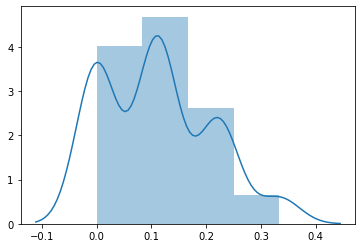

In [162]:
# embeddings = embeddings.numpy()
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)

accuracies = list()
for i in range(len(true_classes)):
    true_class = true_classes[i]
    predicted_classes = true_classes[indices[i]][1:]
    accuracy = (predicted_classes==true_class).sum()/predicted_classes.shape[0]
    accuracies.append(accuracy)

sns.distplot(accuracies)


In [197]:
indices= indices[0:10]

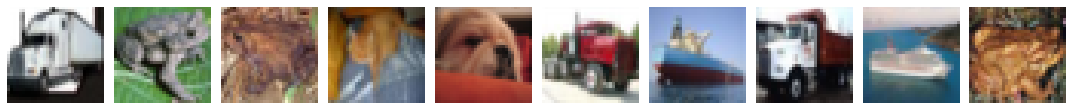

In [220]:
plt.figure(figsize=(15, 3))
for i, image in enumerate(images.numpy()[indices[9]]):
#     print(image.shape)
    plt.subplot(1,indices.shape[1],i+1)
    plt.axis('off')
    plt.imshow(image)
plt.tight_layout()